In [31]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
from IPython import display
d2l.use_svg_display()

In [ ]:
trans=transforms.ToTensor()
mnist_train=torchvision.datasets.FashionMNIST(root='../data',train=True,transform=trans,download=True)
mnist_test=torchvision.datasets.FashionMNIST(root='./data',train=False,transform=trans,download=True)

torch.Size([18, 1, 28, 28])


array([<AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'t-shirt'}>], dtype=object)

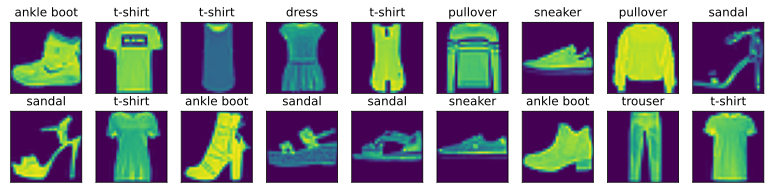

In [8]:
def get_labels(labels):
  text=['t-shirt','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','ankle boot']
  return [text[int(i)] for i in labels]

def show_img(imgs,num_row,num_col, title=None, scale=1.5):
  figsize=(num_col*scale,num_row*scale)
  _, axes = d2l.plt.subplots(num_row, num_col, figsize=figsize)
  axes = axes.flatten()
  for i,(ax,img) in enumerate(zip(axes,imgs)):
    ax.imshow(img.numpy())
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if title:
      ax.set_title(title[i])
  return axes

X,y=next(iter(data.DataLoader(mnist_train,batch_size=18)))
print(X.size())
show_img(X.reshape(18,28,28),2,9,title=get_labels(y))

In [19]:
#建立数据集，测试提取速度
batch_size=256
worker_num=4
train_iter=data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=worker_num)
test_iter=data.DataLoader(mnist_test,batch_size,shuffle=True,num_workers=worker_num)
timer=d2l.Timer()
for X,y in train_iter:
  continue
f'{timer.stop():.2f} secs'

'1.88 secs'

初始化网络

多维tensor的求和机制-axis out to inside , keep the origin dim，

广播机制-计算总和或均值时保持轴数不变会很有用，在对每行进行求和后仍保持两个轴，我们可以通过广播将X_exp除以partition

In [21]:
num_input=28*28
num_output=10
W=torch.normal(0,0.01,(num_input,num_output),requires_grad=True)
#if not num_output can't broadcast
B=torch.zeros(num_output,requires_grad=True)

def softmax(X):
  X_exp=torch.exp(X)
  #axis out to inside, keep the origin dim,
  partition=X_exp.sum(1,keepdim=True)
  return X_exp/partition

xx=torch.normal(0,1,(2,5))
xx=softmax(xx)
xx,xx.sum(1,keepdim=True)


(tensor([[0.0946, 0.3149, 0.1292, 0.3790, 0.0823],
         [0.6756, 0.0244, 0.0795, 0.1437, 0.0768]]),
 tensor([[1.],
         [1.]]))

In [22]:
#将每张原始图像展平为向量, [256,1,28,28]->[256,28*28]
def net(X):
  return softmax(torch.matmul(X.reshape((-1,W.shape[0])),W)+B)

#不使用Python的for循环迭代预测（这往往是低效的）， 而是通过一个批量下标取值运算符选择所有元素
def cross_entropy(y_hat,y):
  return -torch.log(y_hat[range(len(y_hat)),y])

#
def accuracy(y_hat,y):
  if len(y_hat.shape)>1 and y_hat.shape[1]>1:
    y_hat=y_hat.argmax(axis=1)
  #由于等式运算符“==”对数据类型很敏感
  cmp=y_hat.type(y.dtype)==y
  return float(cmp.sum())

def evaluate_accuracy(net,data_iter):
  if isinstance(net,torch.nn.Module):
    net.eval() # 将模型设置为评估模式,不加会怎样？
  #在Accumulator实例中创建了2个变量， 分别用于存储正确预测的数量和预测的总数量
  metric=d2l.Accumulator(2)
  with torch.no_grad():
    for X,y in data_iter:
      metric.add(accuracy(net(X),y),y.numel())
  return metric[0]/metric[1] 

  
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]
accuracy(y_hat,y)/len(y)
evaluate_accuracy(net,test_iter)

0.104

训练

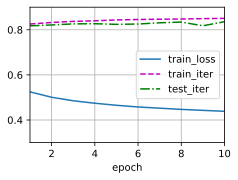

In [32]:
def train_epoch(net,train_iter,loss,updater):
  if isinstance(net,torch.nn.Module):
    net.train()
  metric=d2l.Accumulator(3)
  for X,y in train_iter:
    y_hat=net(X)
    l=loss(y_hat,y)
    if isinstance(net,torch.nn.Module):
      updater.zero_grad()
      l.mean().backward()
      updater.step()
    else:
      l.sum().backward()
      updater(X.shape[0])
    metric.add(l.sum(),accuracy(y_hat,y),y.numel())
  return metric[0]/metric[2],metric[1]/metric[2]

def train(net,train_iter,test_iter,loss,num_epoch,updater):
  animator=Animator(xlabel='epoch',xlim=[1,num_epoch],ylim=[0.3,0.9],legend=['train_loss','train_acc','test_acc'])
  for epoch in range(num_epoch):
    train_loss,train_acc=train_epoch(net,train_iter,loss,updater)
    test_acc=evaluate_accuracy(net,test_iter)
    animator.add(epoch+1,(train_loss,train_acc,test_acc))
  assert train_loss<0.5,train_loss
  assert train_acc>0.7 and train_acc<=1 ,train_acc
  assert test_acc>0.7 and test_acc<=1,test_acc

def updater(batch_size):
  return d2l.sgd([W,B],0.1,batch_size)

num_epoch=10
train(net,train_iter,test_iter,cross_entropy,num_epoch,updater) 


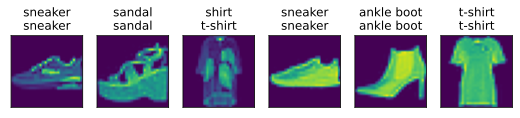

In [33]:
def predict(net,test_iter,n=6):
  for X,y in test_iter:
    break
  true_label=get_labels(y)
  pred_label=get_labels(net(X).argmax(axis=1))
  title=[true+'\n'+pred for true,pred in zip(true_label,pred_label)]
  d2l.show_images(X[0:n].reshape((-1,28,28)),1,n,titles=title)

predict(net,test_iter)

In [23]:
#绘制图片
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

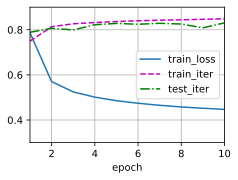

In [34]:
from torch import nn
net=nn.Sequential(nn.Flatten(),nn.Linear(28*28,10))
def init_weights(m):
  if type(m)==nn.Linear:
    nn.init.normal_(m.weight,std=0.01)
  
net.apply(init_weights)
loss=nn.CrossEntropyLoss(reduction='none')
trainer=torch.optim.SGD(net.parameters(),lr=0.1)
num_epochs=10
train(net,train_iter,test_iter,loss,num_epoch,trainer)

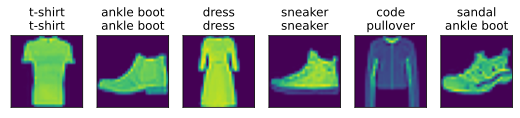

In [36]:
predict(net,test_iter)